In [1]:
import baccoemu
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import scipy
import warnings

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plot_utils
import plotter
import utils
import run_inference as rinf
import moment_network as mn

%load_ext autoreload
%autoreload 2

2024-11-22 01:04:25.058583: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 01:04:25.300950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 01:04:25.300986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 01:04:25.323982: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 01:04:25.400670: I tensorflow/core/platform/cpu_feature_guar

2024-11-22 01:04:27.519135: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 

### Results

In [3]:
plot_dir = '../plots/plots_2024-10-09'
save_plots = False

data_mode = 'muchisimocksPk'
if data_mode == 'emuPk':
    n_rlzs_per_cosmo = 9
    tag_emuPk = '_2param'
    tag_errG = f'_boxsize500'
    tag_datagen = f'{tag_emuPk}{tag_errG}_nrlzs{n_rlzs_per_cosmo}'
    tag_data = '_'+data_mode + tag_datagen + tag_errG
elif data_mode == 'muchisimocksPk':
    tag_mocks = '_p5_n10000'
    #tag_pk = '_b1000'
    tag_pk = '_biaszen_p4_n10000'
    tag_datagen = f'{tag_mocks}{tag_pk}'
    tag_data = '_'+data_mode + tag_datagen


In [4]:
if data_mode == 'emuPk':
    # leave this fixed so we don't mix the sets; then we'll subsample
    frac_train=0.8
    frac_val=0.1
    frac_test=0.1
elif data_mode == 'muchisimocksPk':
    frac_train=0.8
    frac_val=0.1
    frac_test=0.1

In [5]:
if data_mode == 'emuPk':
    theta, y, y_err, k, param_names, bias_params, random_ints = rinf.load_data_emuPk(tag_emuPk, tag_errG, tag_datagen)
elif data_mode == 'muchisimocksPk':
    theta, y, y_err, k, param_names, bias_params, random_ints = rinf.load_data_muchisimocksPk(tag_mocks, tag_pk, mode_bias_vector='LH')

4458/4458 have at least one non-positive Pk value
Masking columns [29]


In [6]:
idxs_train, idxs_val, idxs_test = utils.idxs_train_val_test(random_ints, 
                                frac_train=frac_train, frac_val=frac_val, frac_test=frac_test,
                                N_tot=10000)

# only need this when havent finished generating dataset
n_train, n_val, n_test = 3500, 400, 400
idxs_train = idxs_train[:n_train]
idxs_test = idxs_test[:n_test]
idxs_val = idxs_val[:n_val]

theta_train, theta_val, theta_test = utils.split_train_val_test(theta, idxs_train, idxs_val, idxs_test)
y_train, y_val, y_test = utils.split_train_val_test(y, idxs_train, idxs_val, idxs_test)
y_err_train, y_err_val, y_err_test = utils.split_train_val_test(y_err, idxs_train, idxs_val, idxs_test)

0.8 0.1 0.1
8000 9000


In [7]:
print(len(theta_train), len(theta_val), len(theta_test))

3500 400 400


In [8]:
param_labels = [utils.param_label_dict[param_name] for param_name in param_names]

In [9]:
# only need for bounds, TODO save bounds somwehere
dir_emus_lbias = '/home/kstoreyf/external'
emu, emu_bounds, emu_param_names = utils.load_emu(dir_emus_lbias=dir_emus_lbias)
dict_bounds = {name: emu_bounds[emu_param_names.index(name)] for name in param_names}

Loading l-bias lpt emulator...


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using ver

Nonlinear l-bias emulator loaded in memory.


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Results for specific model

In [10]:
n_train = 3500
#tag_inf = f'{tag_data}_ntrain{n_train}_diagcov'
#tag_inf = f'{tag_data}_ntrain{n_train}'
#tag_inf = f'{tag_data}_ntrain{n_train}_diagcov_scalecovlog'
#tag_inf = f'{tag_data}_ntrain{n_train}_diagcov_scalecovnone'
#tag_inf = f'{tag_data}_ntrain{n_train}_eigs'
#tag_inf = f'{tag_data}_ntrain{n_train}_direct'
run_mode_mean = 'best'
sweep_name_mean = 'rand10'
run_mode_cov = 'single'
sweep_name_cov = None
if run_mode_mean == 'sweep':
    tag_run = f'_sweep-{sweep_name_mean}'
elif run_mode_mean == 'best':
    tag_run = f'_best-{sweep_name_mean}'
tag_inf = f'{tag_data}_ntrain{n_train}_direct{tag_run}'
dir_mn = f'../results/results_moment_network/mn{tag_inf}'

In [11]:
print(tag_inf)

_muchisimocksPk_p5_n10000_biaszen_p4_n10000_ntrain3500_direct_best-rand10


In [12]:
theta_test_pred = np.load(f'{dir_mn}/theta_test_pred.npy')
covs_test_pred = np.load(f'{dir_mn}/covs_test_pred.npy')
print(theta_test_pred.shape, covs_test_pred.shape)

(400, 5) (400, 5, 5)


In [13]:
covs_test = np.load(f'{dir_mn}/covs_test.npy')
print(covs_test.shape)

(400, 5, 5)


In [14]:
print(covs_test_pred[0])
print(covs_test[0])

[[ 1.92137535e-03 -2.64786110e-04 -2.64786110e-04 -2.64786110e-04
  -2.64786110e-04]
 [-2.64786110e-04  4.63215082e-03 -2.57455348e-04 -2.57455348e-04
  -2.57455348e-04]
 [-2.57455348e-04  4.05195998e-06  3.26458191e-03  3.51757692e-05
   3.51757692e-05]
 [ 3.51757692e-05 -2.11214599e-06 -3.55261155e-06  3.40481128e-05
   1.15999292e-05]
 [ 1.15999292e-05 -5.56733891e-05 -4.37898519e-05  6.53297250e-07
   6.37604584e-04]]
[[ 6.15894448e-04  1.81229815e-03  1.81229815e-03  1.81229815e-03
   1.81229815e-03]
 [ 1.81229815e-03  5.33277188e-03 -1.64144599e-03 -1.64144599e-03
  -1.64144599e-03]
 [-1.64144599e-03 -4.83003143e-03  4.37468621e-03 -5.38553581e-05
  -5.38553581e-05]
 [-5.38553581e-05 -1.58471904e-04  1.43532162e-04  4.70924783e-06
   6.11395399e-04]
 [ 6.11395399e-04  1.79905949e-03 -1.62945539e-03 -5.34619499e-05
   6.06929215e-04]]


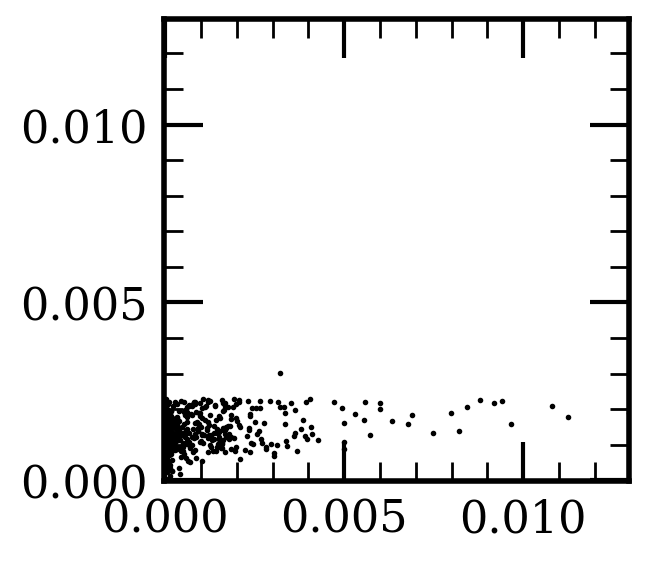

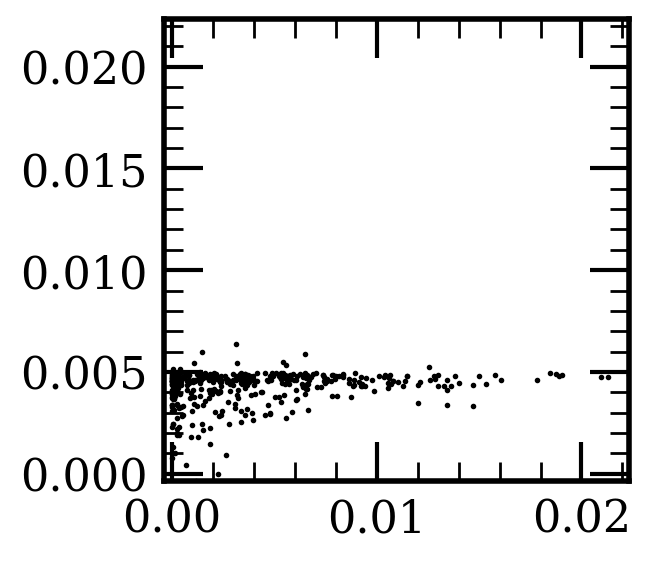

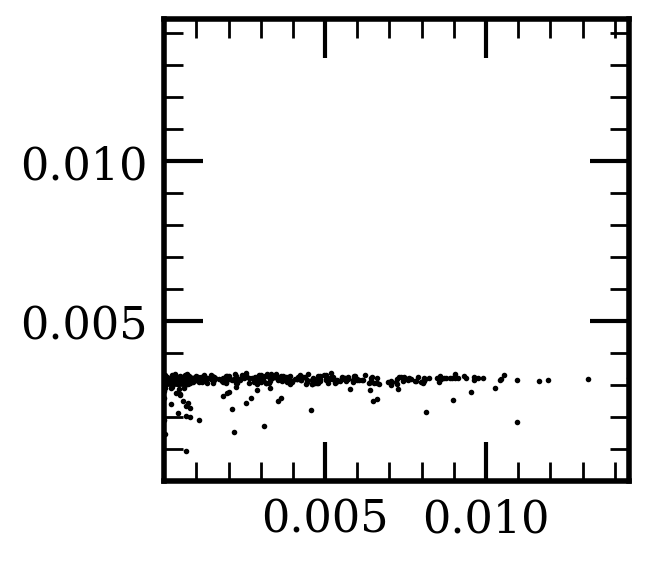

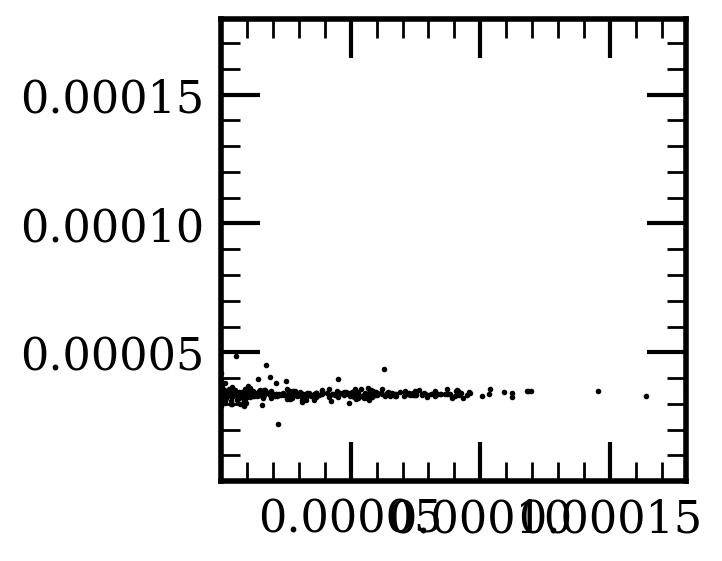

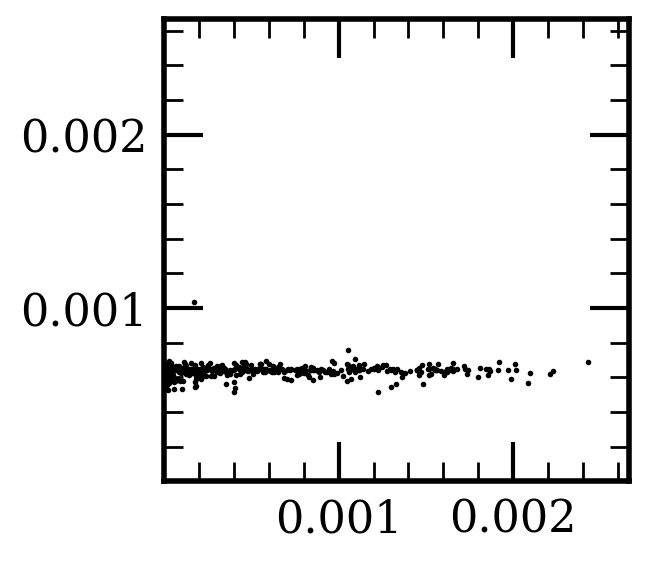

In [15]:
for i in range(covs_test.shape[1]):
    for j in range(covs_test.shape[2]):
        if i!=j:
            continue
        plt.figure(figsize=(3,3))
        plt.scatter(covs_test[:,i,j], covs_test_pred[:,i,j], color='k', s=1)
        plt.xlim(min(np.min(covs_test[:,i,j]), np.min(covs_test_pred[:,i,j])),
                max(np.max(covs_test[:,i,j]), np.max(covs_test_pred[:,i,j])))
        plt.ylim(min(np.min(covs_test[:,i,j]), np.min(covs_test_pred[:,i,j])),
                max(np.max(covs_test[:,i,j]), np.max(covs_test_pred[:,i,j])))



In [16]:
# moment_network = mn.MomentNetwork(tag_mn=tag_inf)
# moment_network.load_model_mean()
history_mean = np.load(f'{dir_mn}/model_mean_history.npy', allow_pickle=True).item()
history_cov = np.load(f'{dir_mn}/model_cov_history.npy', allow_pickle=True).item()

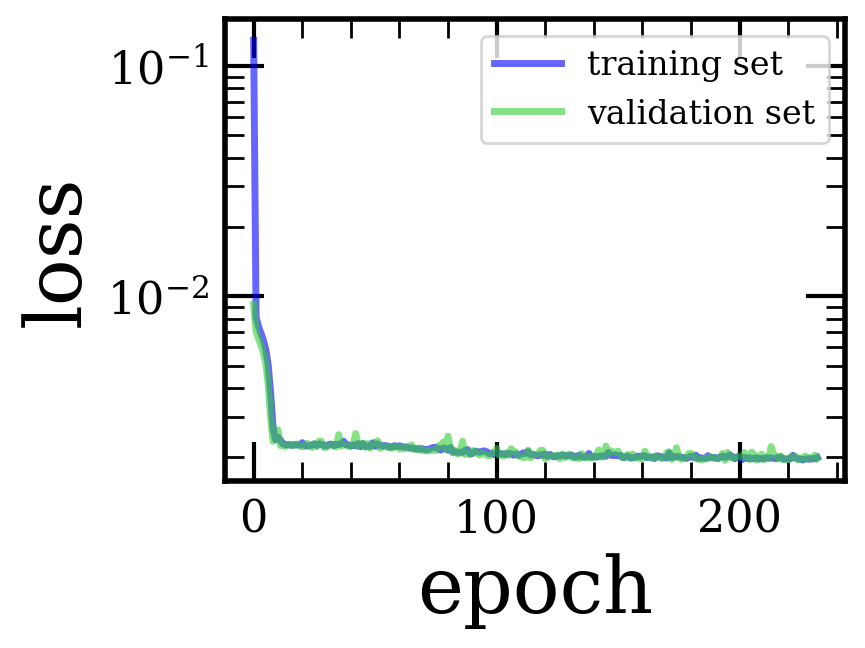

In [17]:
plotter.plot_loss(history_mean)

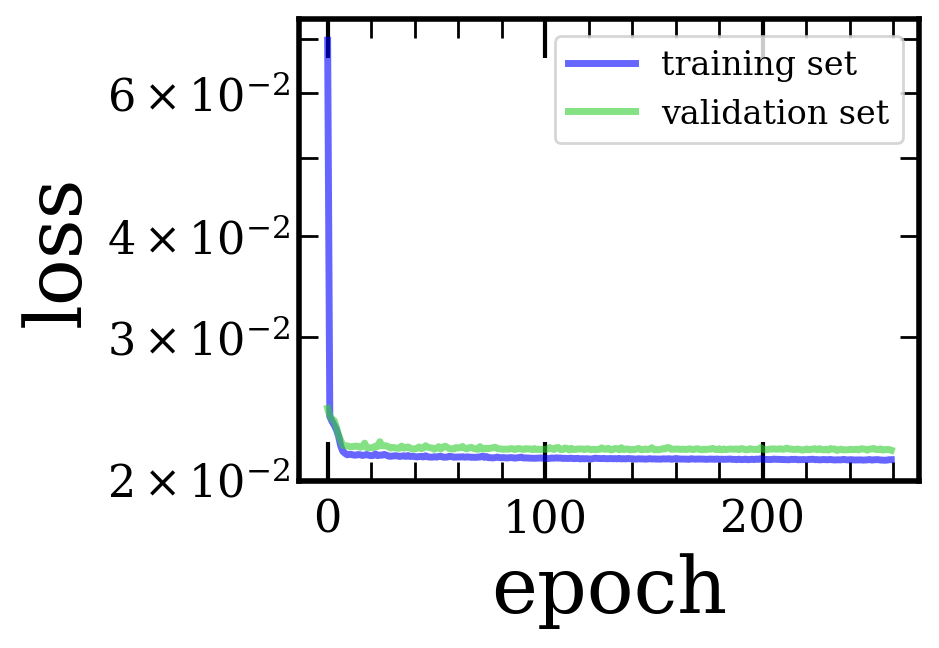

In [18]:
plotter.plot_loss(history_cov)

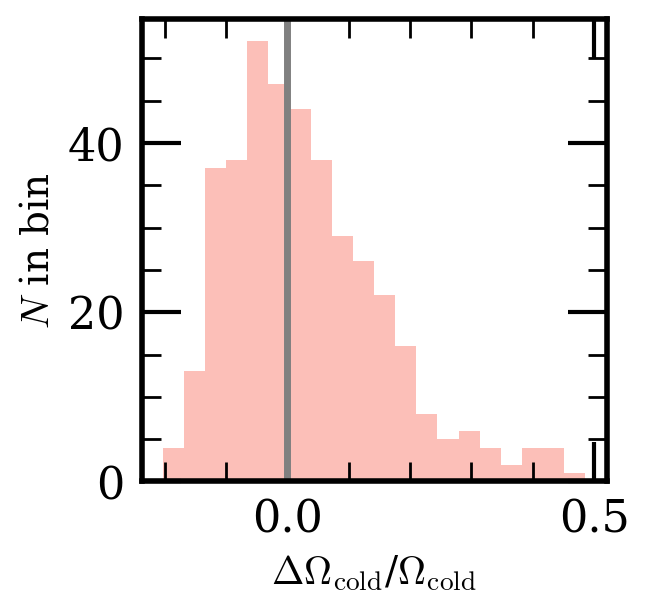

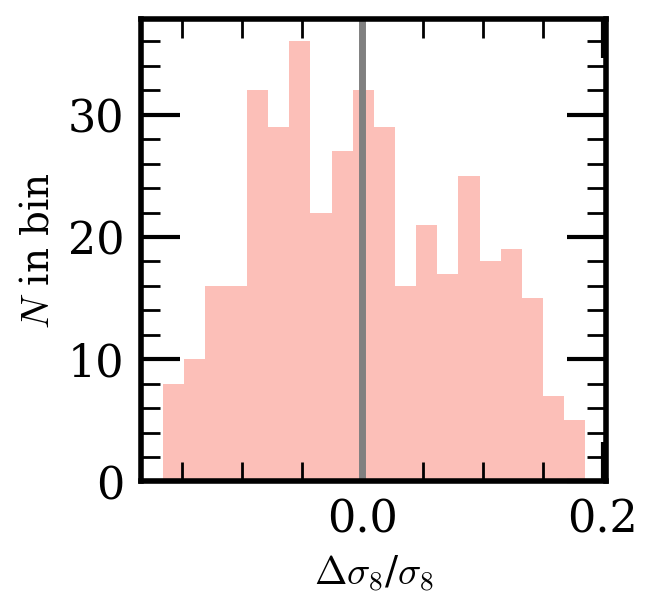

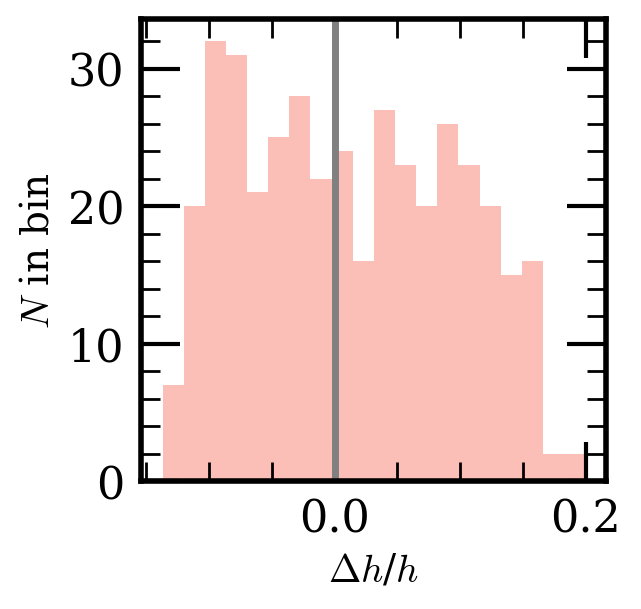

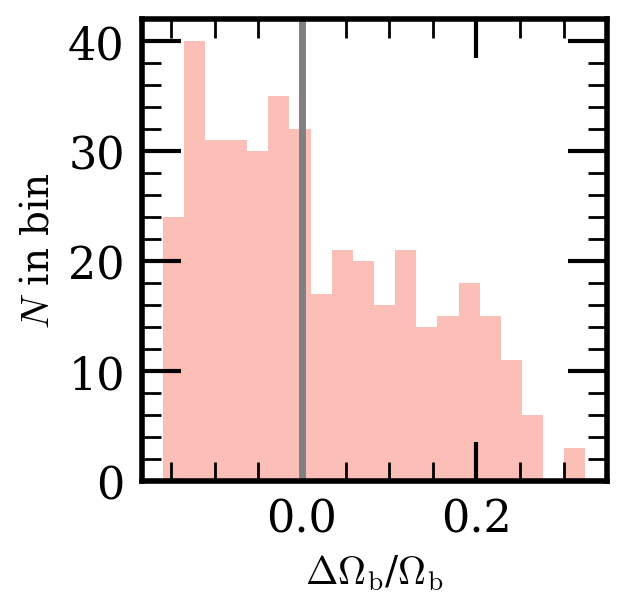

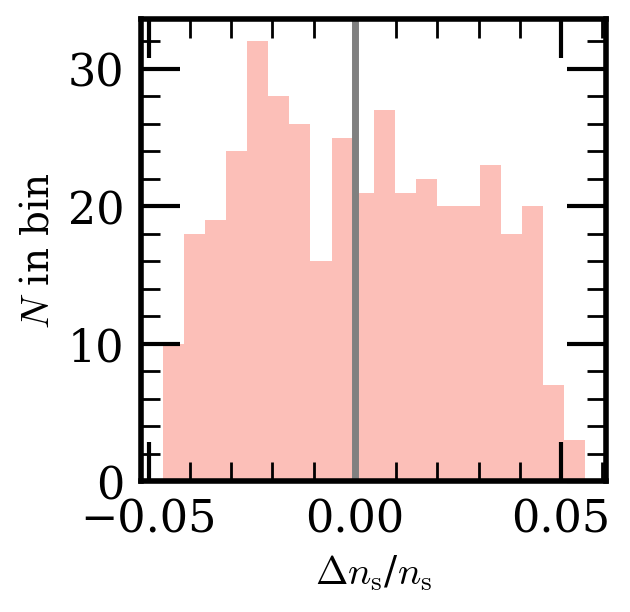

In [19]:

fracdiffs = (theta_test_pred - theta_test)/theta_test
plotter.plot_hists_mean(fracdiffs, param_labels)


/dipc/kstoreyf/muchisimocks/scripts/plotter.py:94: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(np.diag(cov_pred))


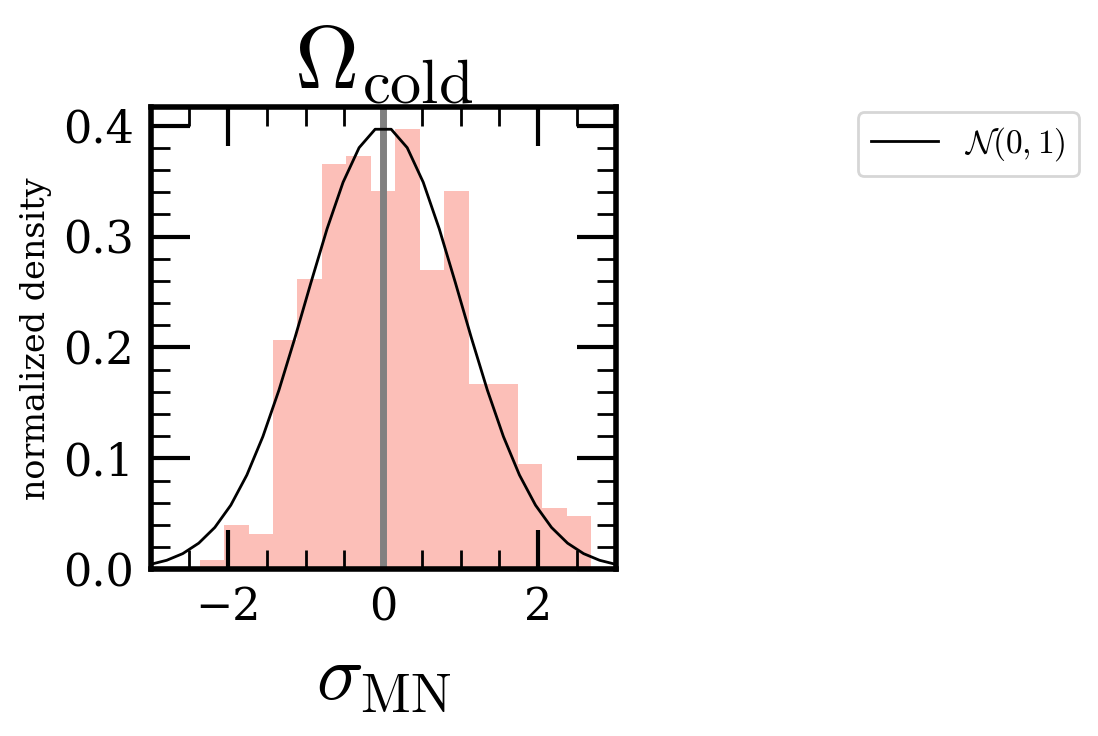

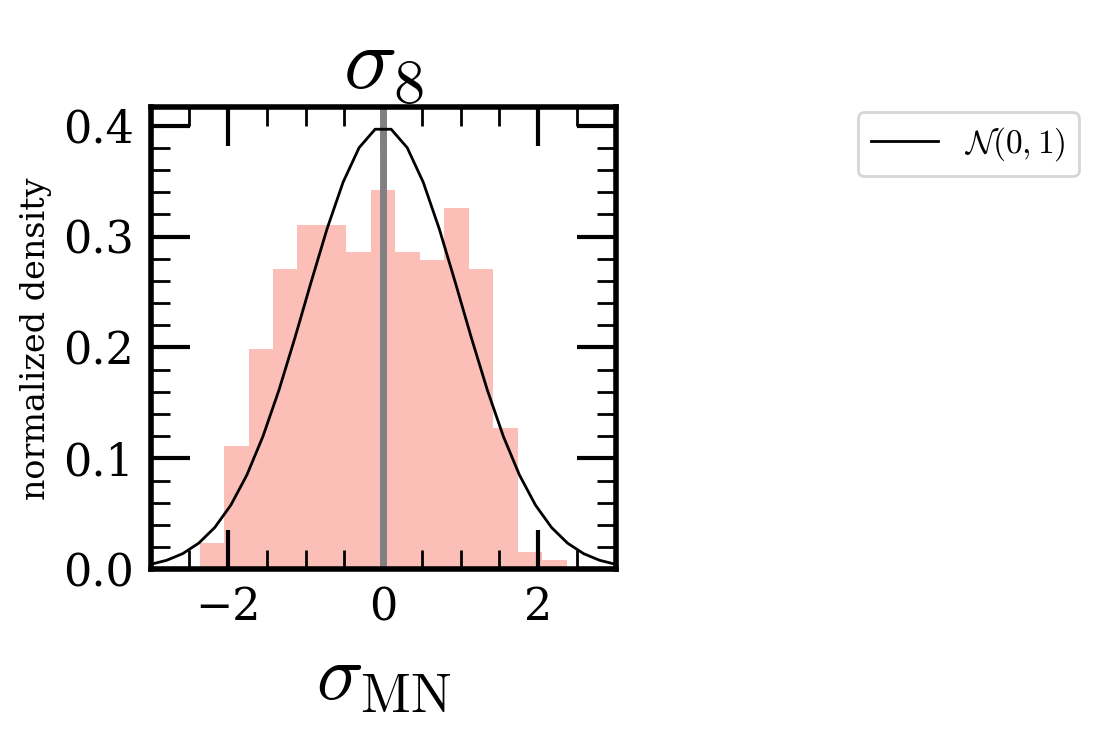

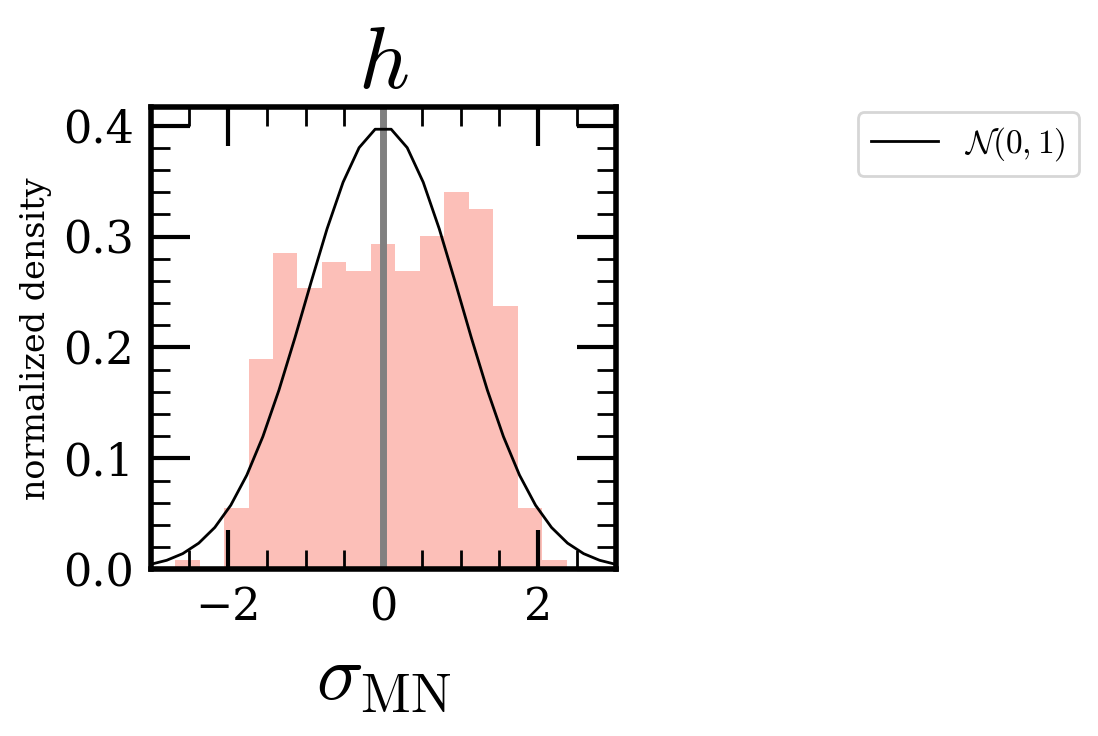

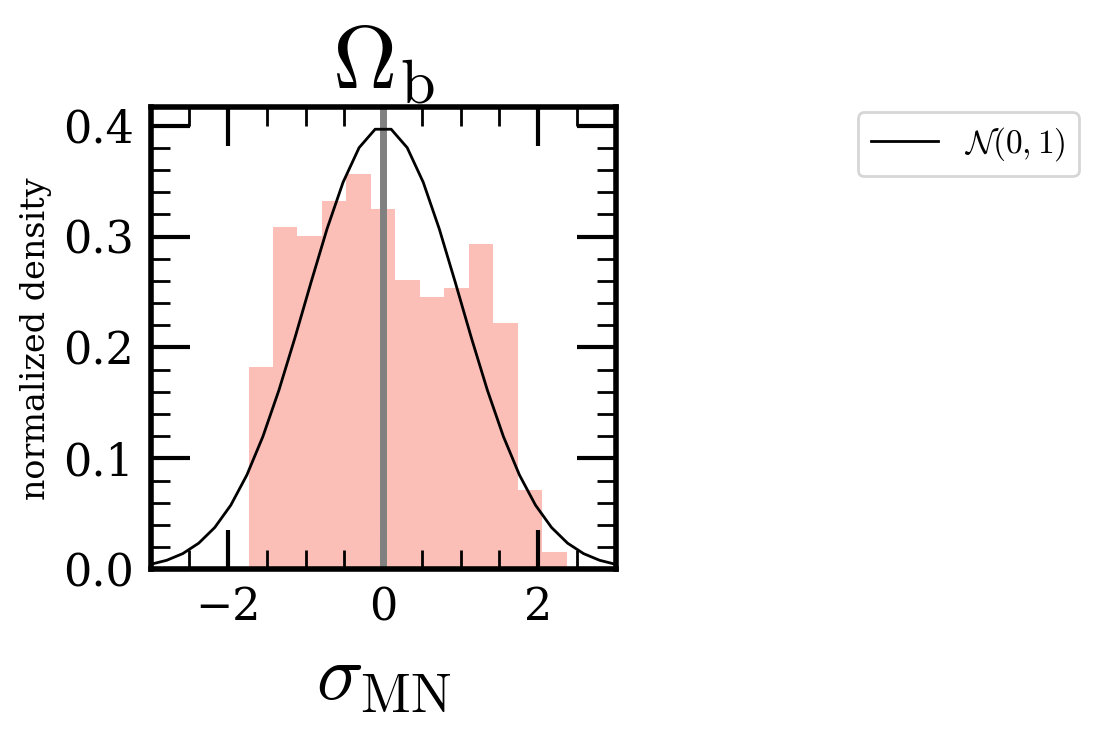

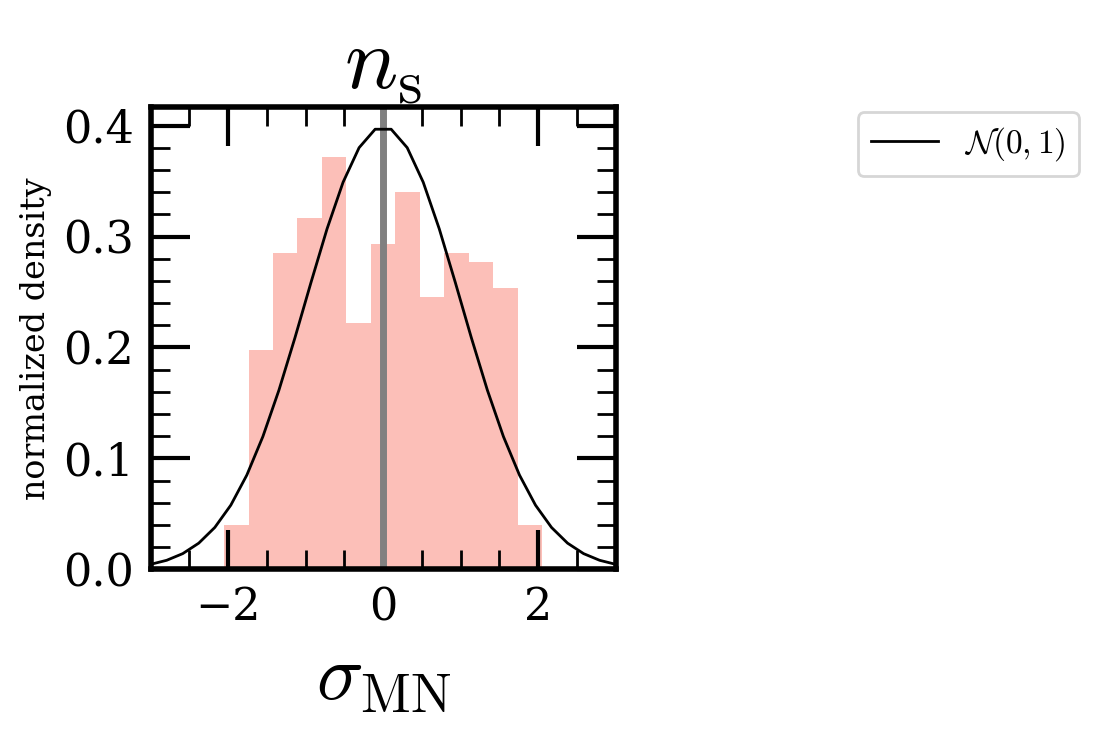

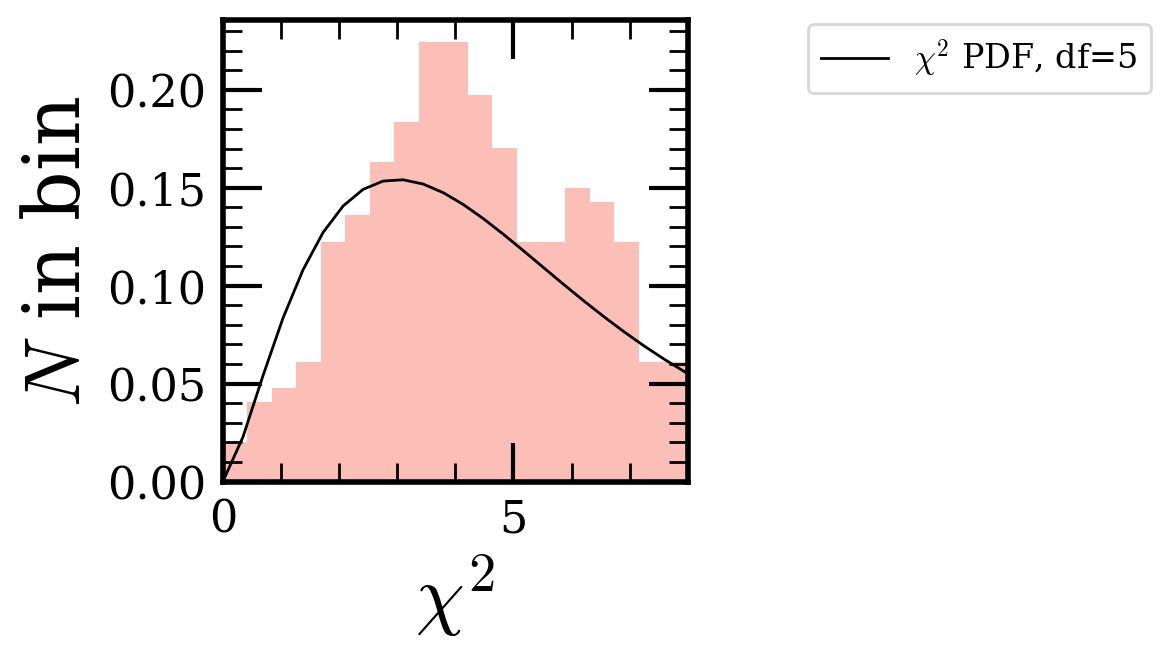

In [20]:
plotter.plot_hists_cov(theta_test, theta_test_pred, covs_test_pred, param_labels)

Covariance matrix not PSD! (sampling anyway)
Covariance matrix not PSD! (sampling anyway)
Covariance matrix not PSD! (sampling anyway)


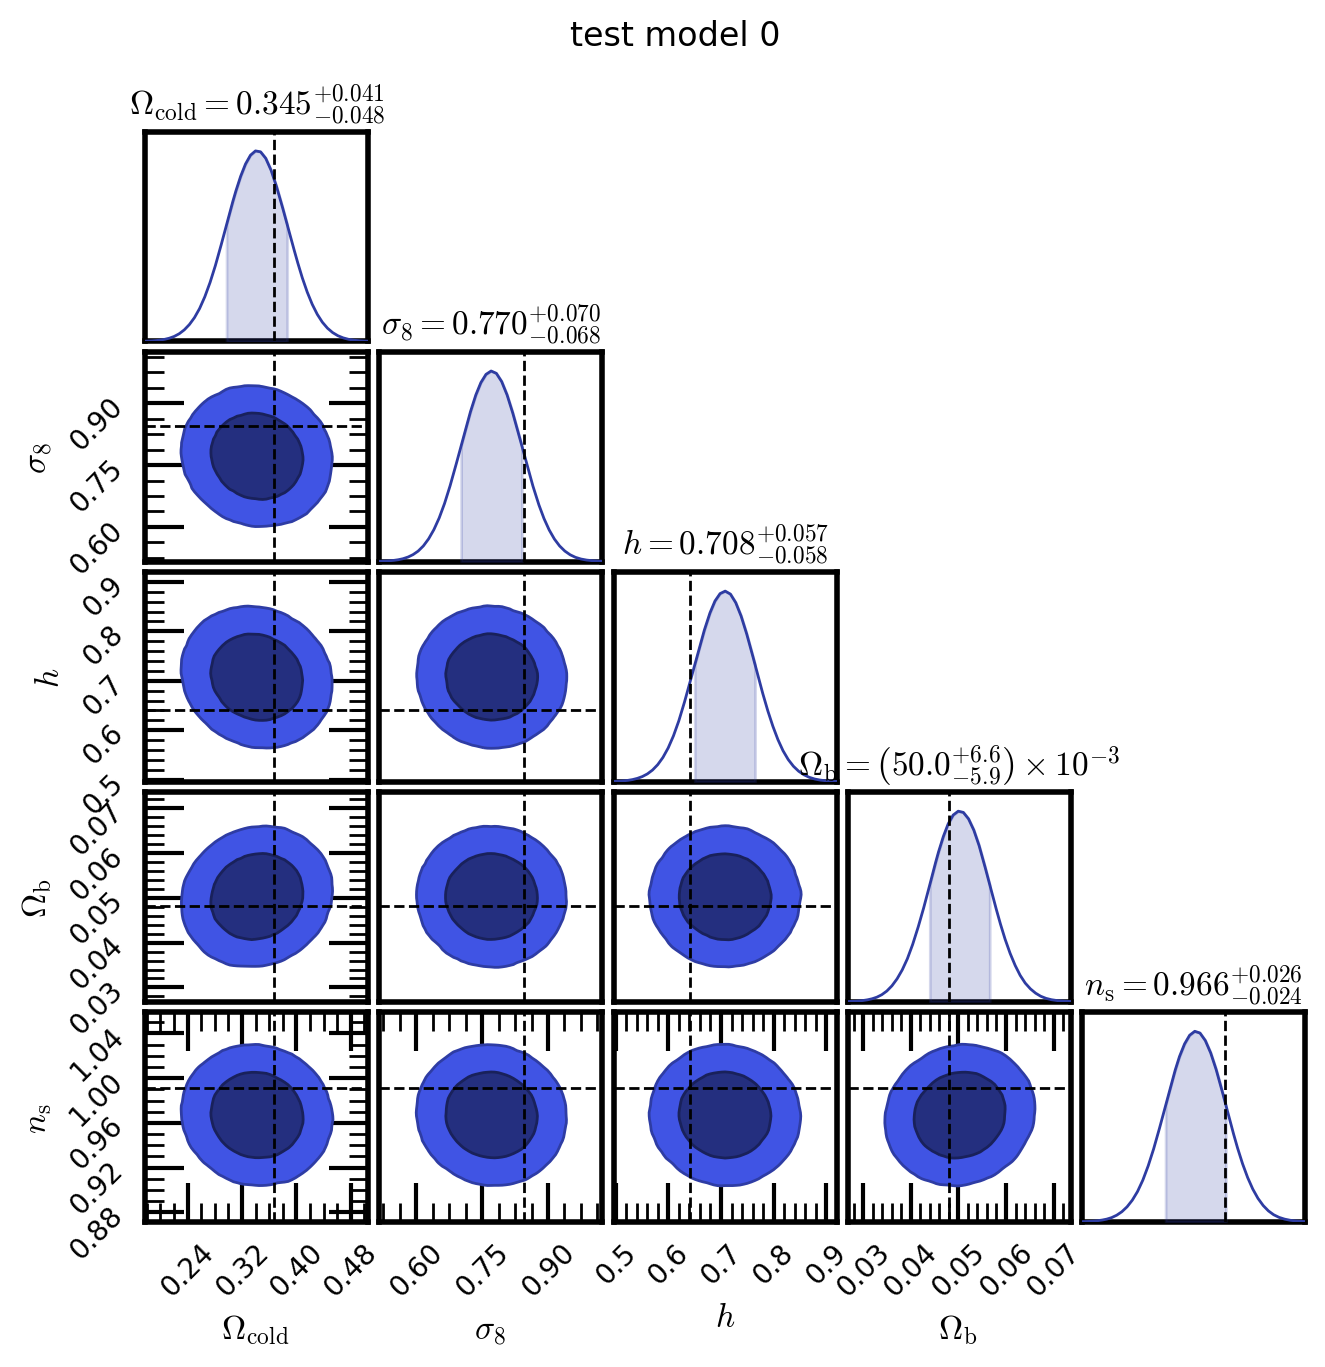

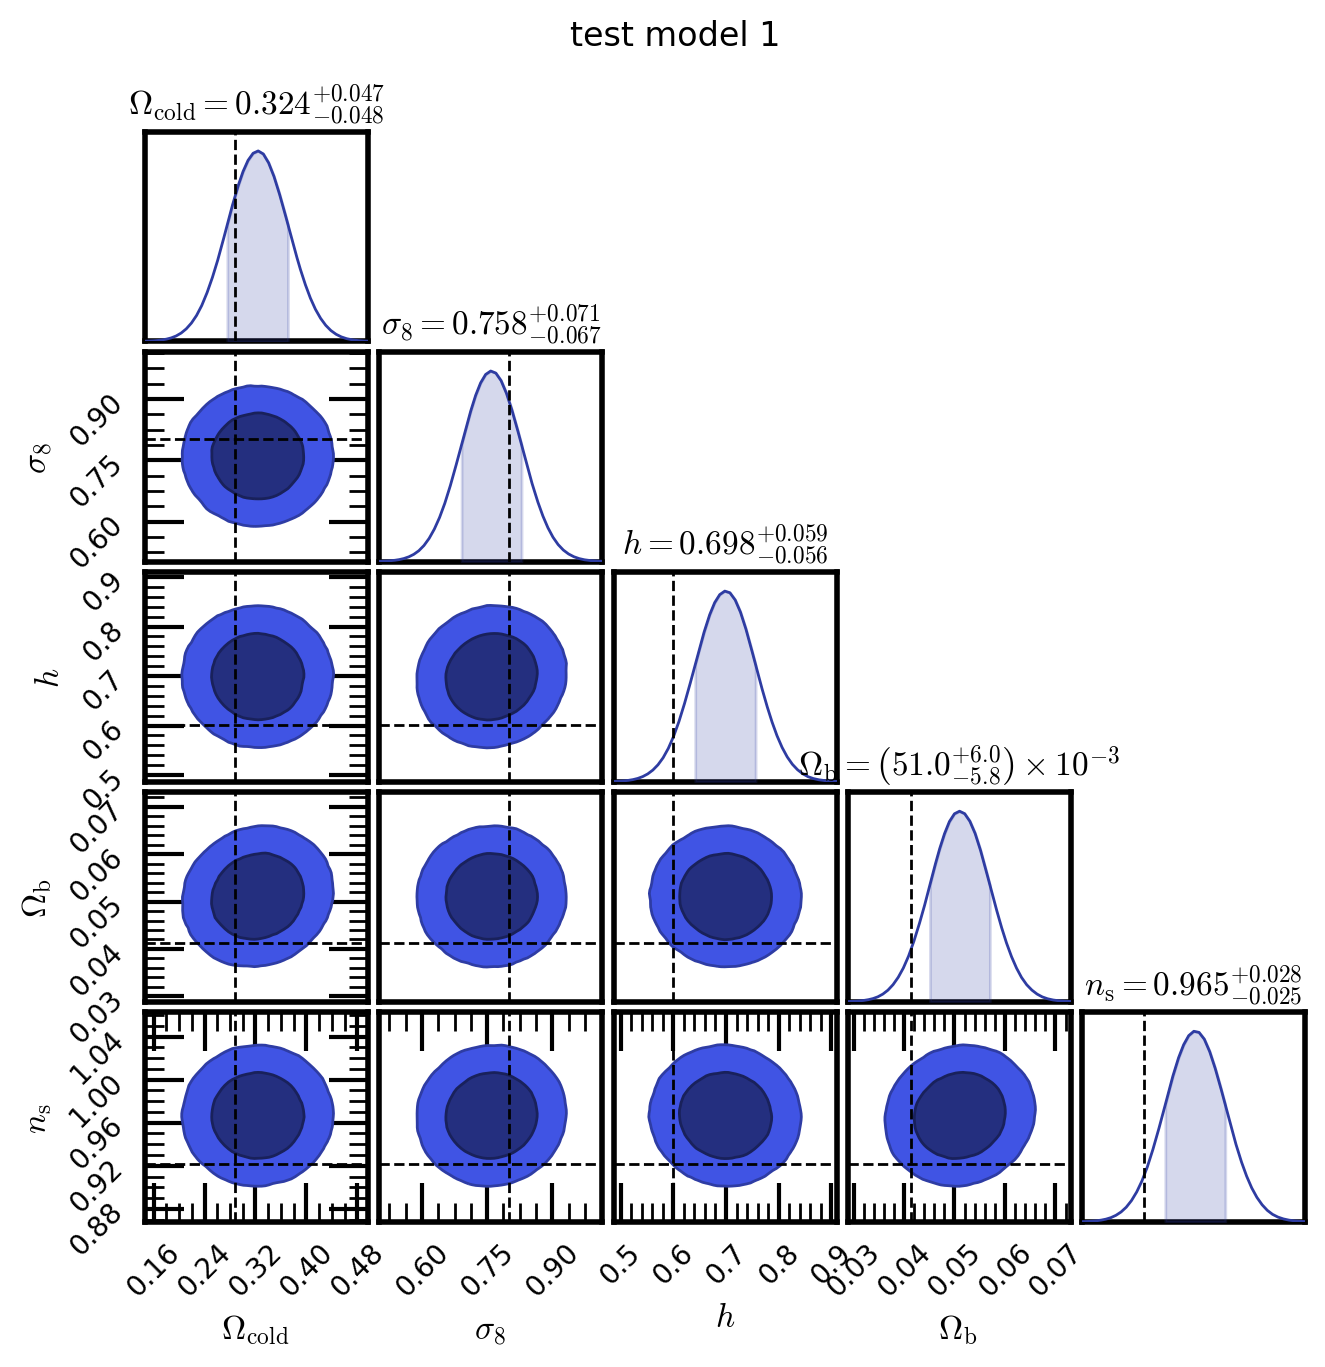

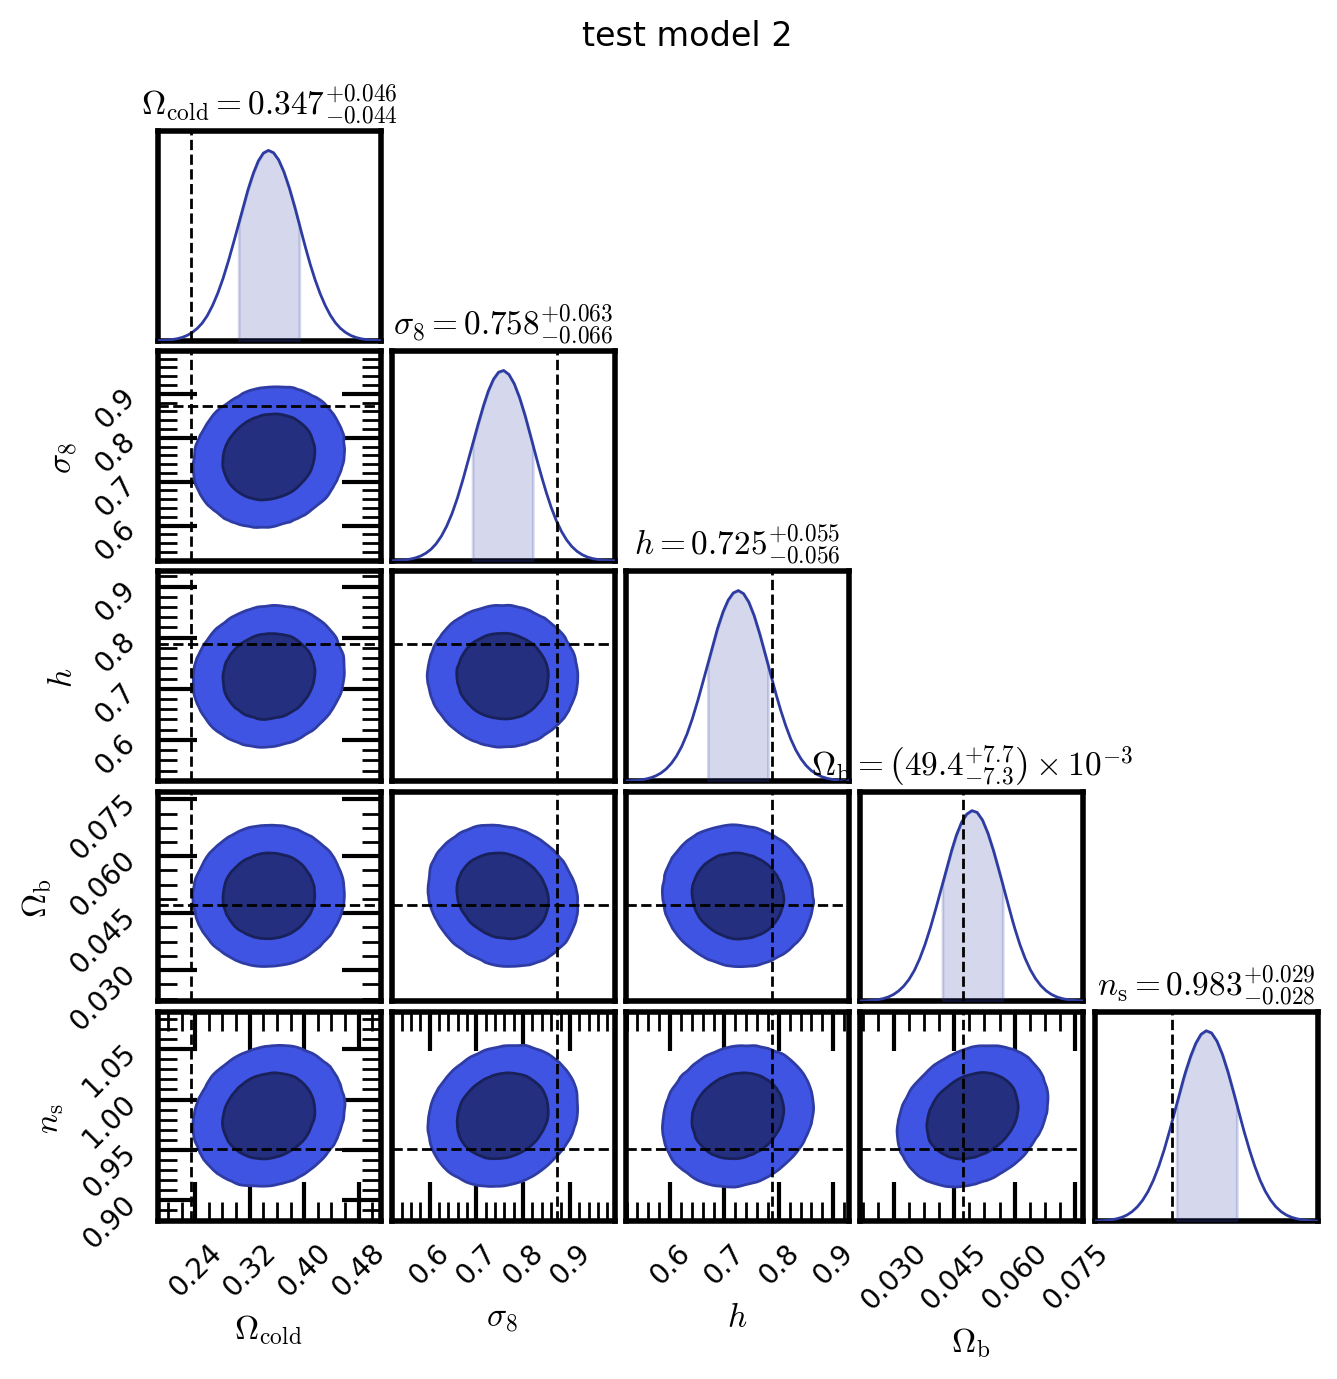

In [21]:
inf_methods = ['mn']
labels_extra = ['']
#colors = [utils.color_dict_methods[meth] for meth in methods]
colors = ['#2E3CA2']

for idx_obs in range(3):
    theta_obs_true = theta_test[idx_obs]
    plotter.plot_contours_inf(param_names, idx_obs, theta_obs_true, 
                            inf_methods, [tag_inf], 
                            colors=colors, labels_extra=labels_extra)



In [22]:
tag_data

'_muchisimocksPk_p5_n10000_biaszen_p4_n10000'

Covariance matrix not PSD! (sampling anyway)
Covariance matrix not PSD! (sampling anyway)
Covariance matrix not PSD! (sampling anyway)
Covariance matrix not PSD! (sampling anyway)
Covariance matrix not PSD! (sampling anyway)
Covariance matrix not PSD! (sampling anyway)


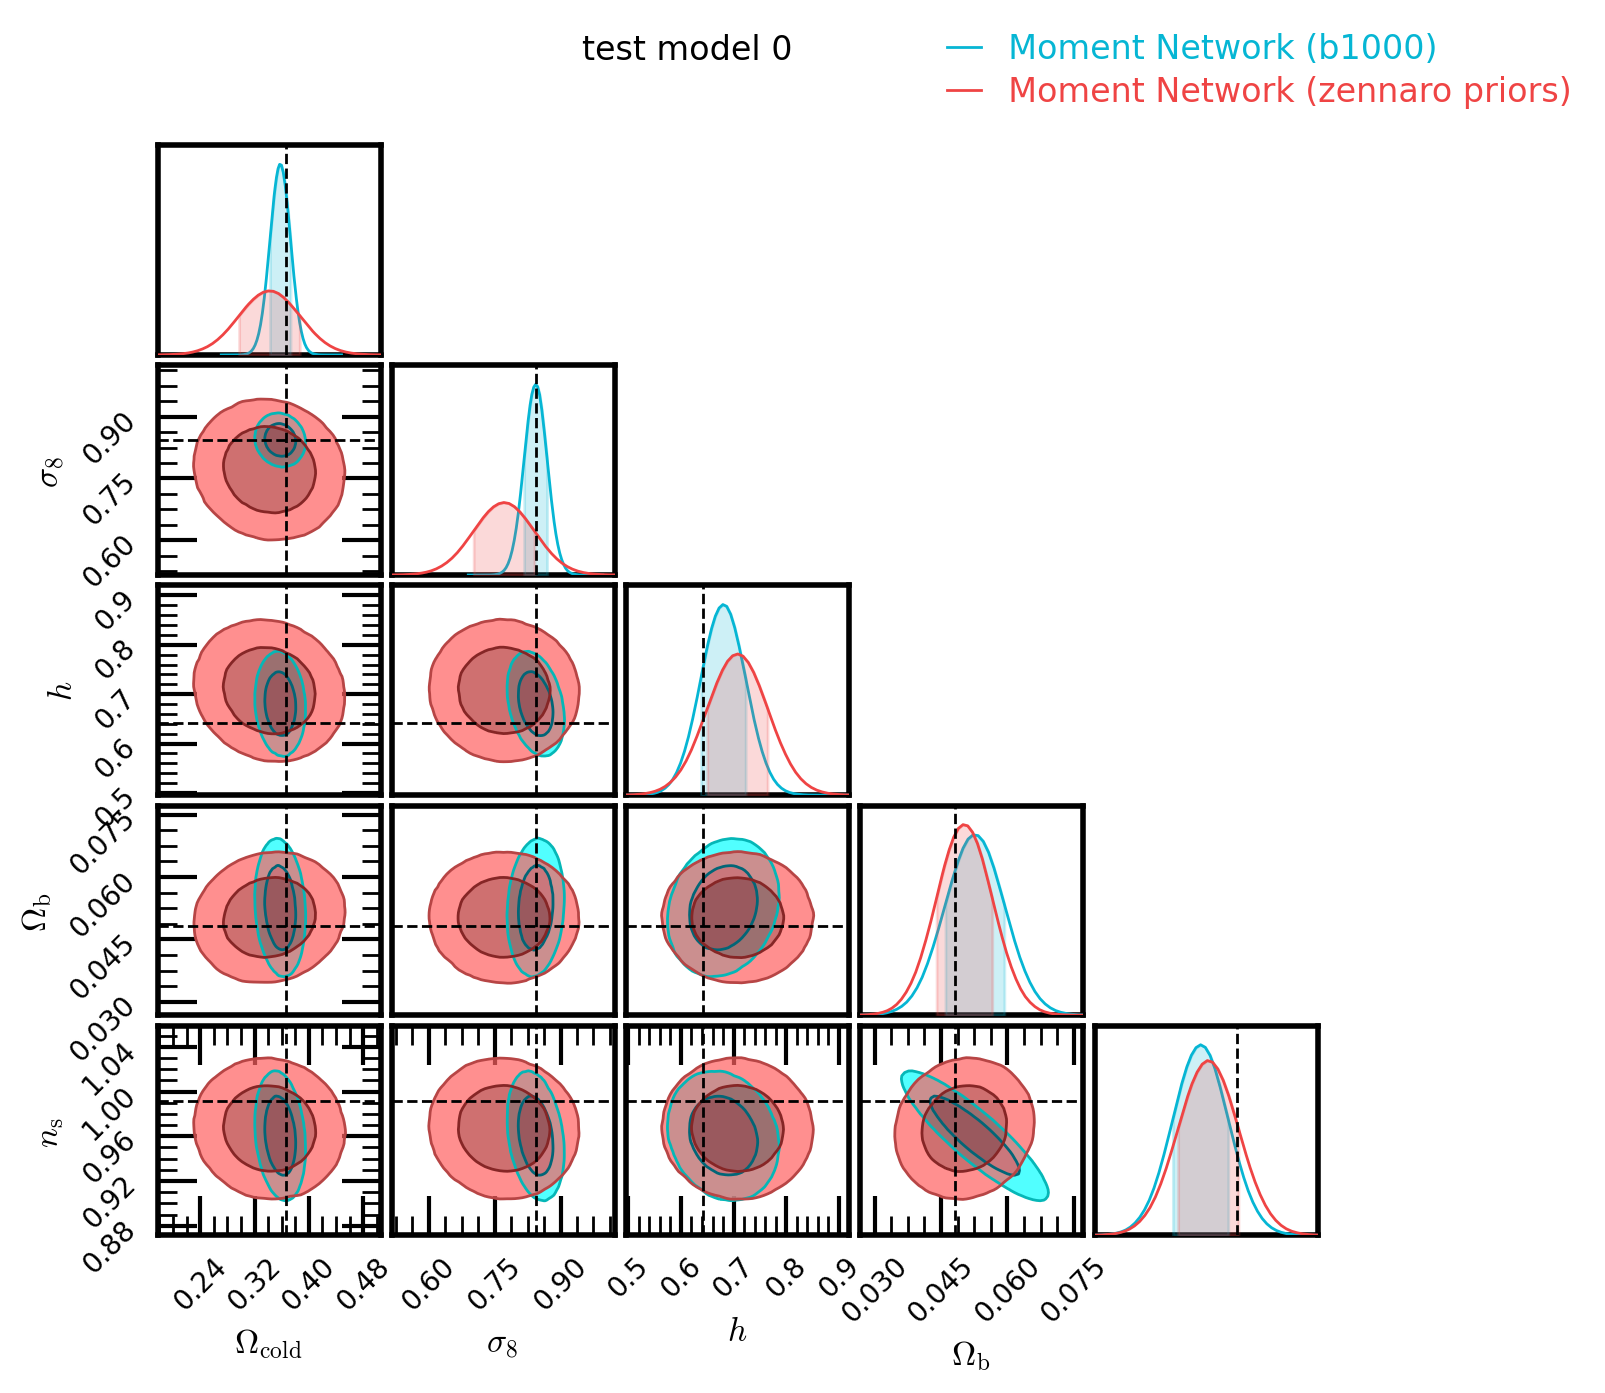

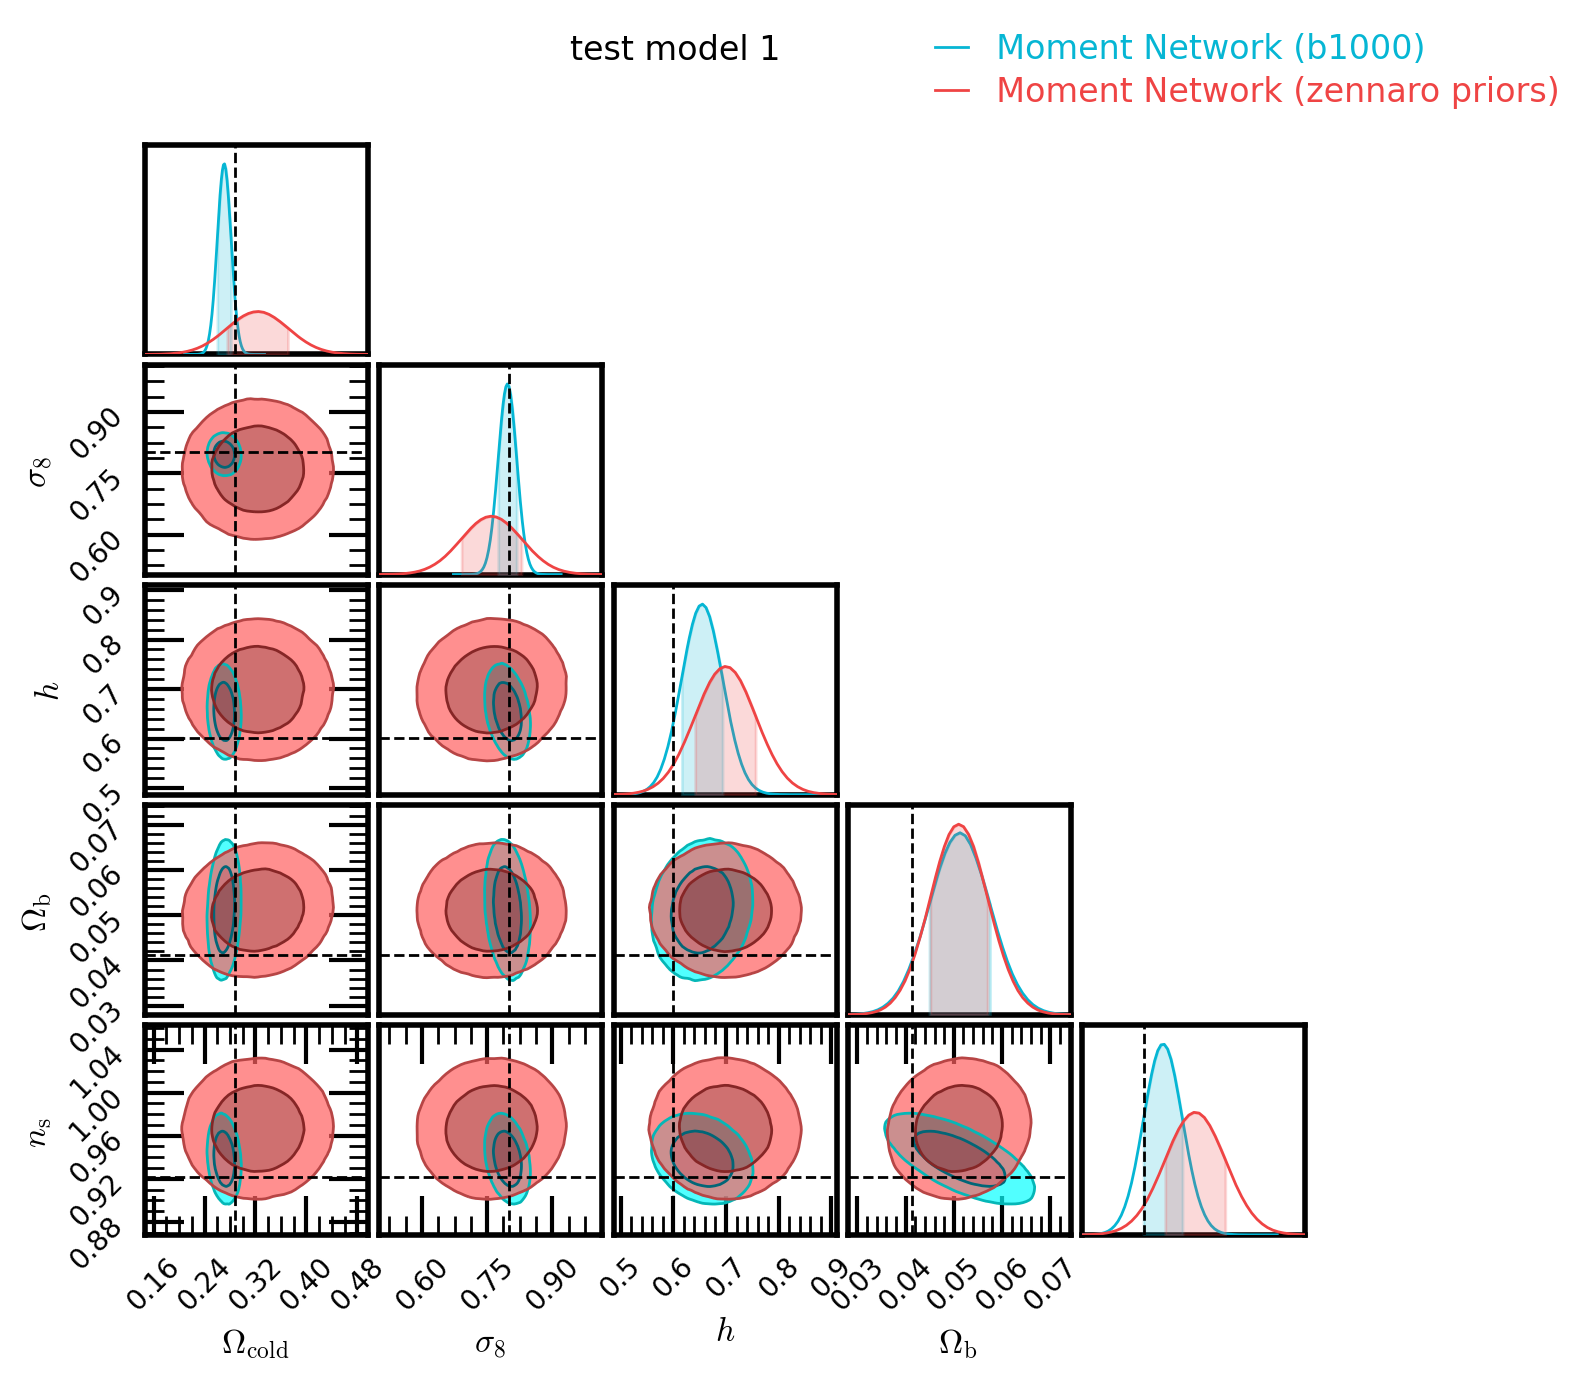

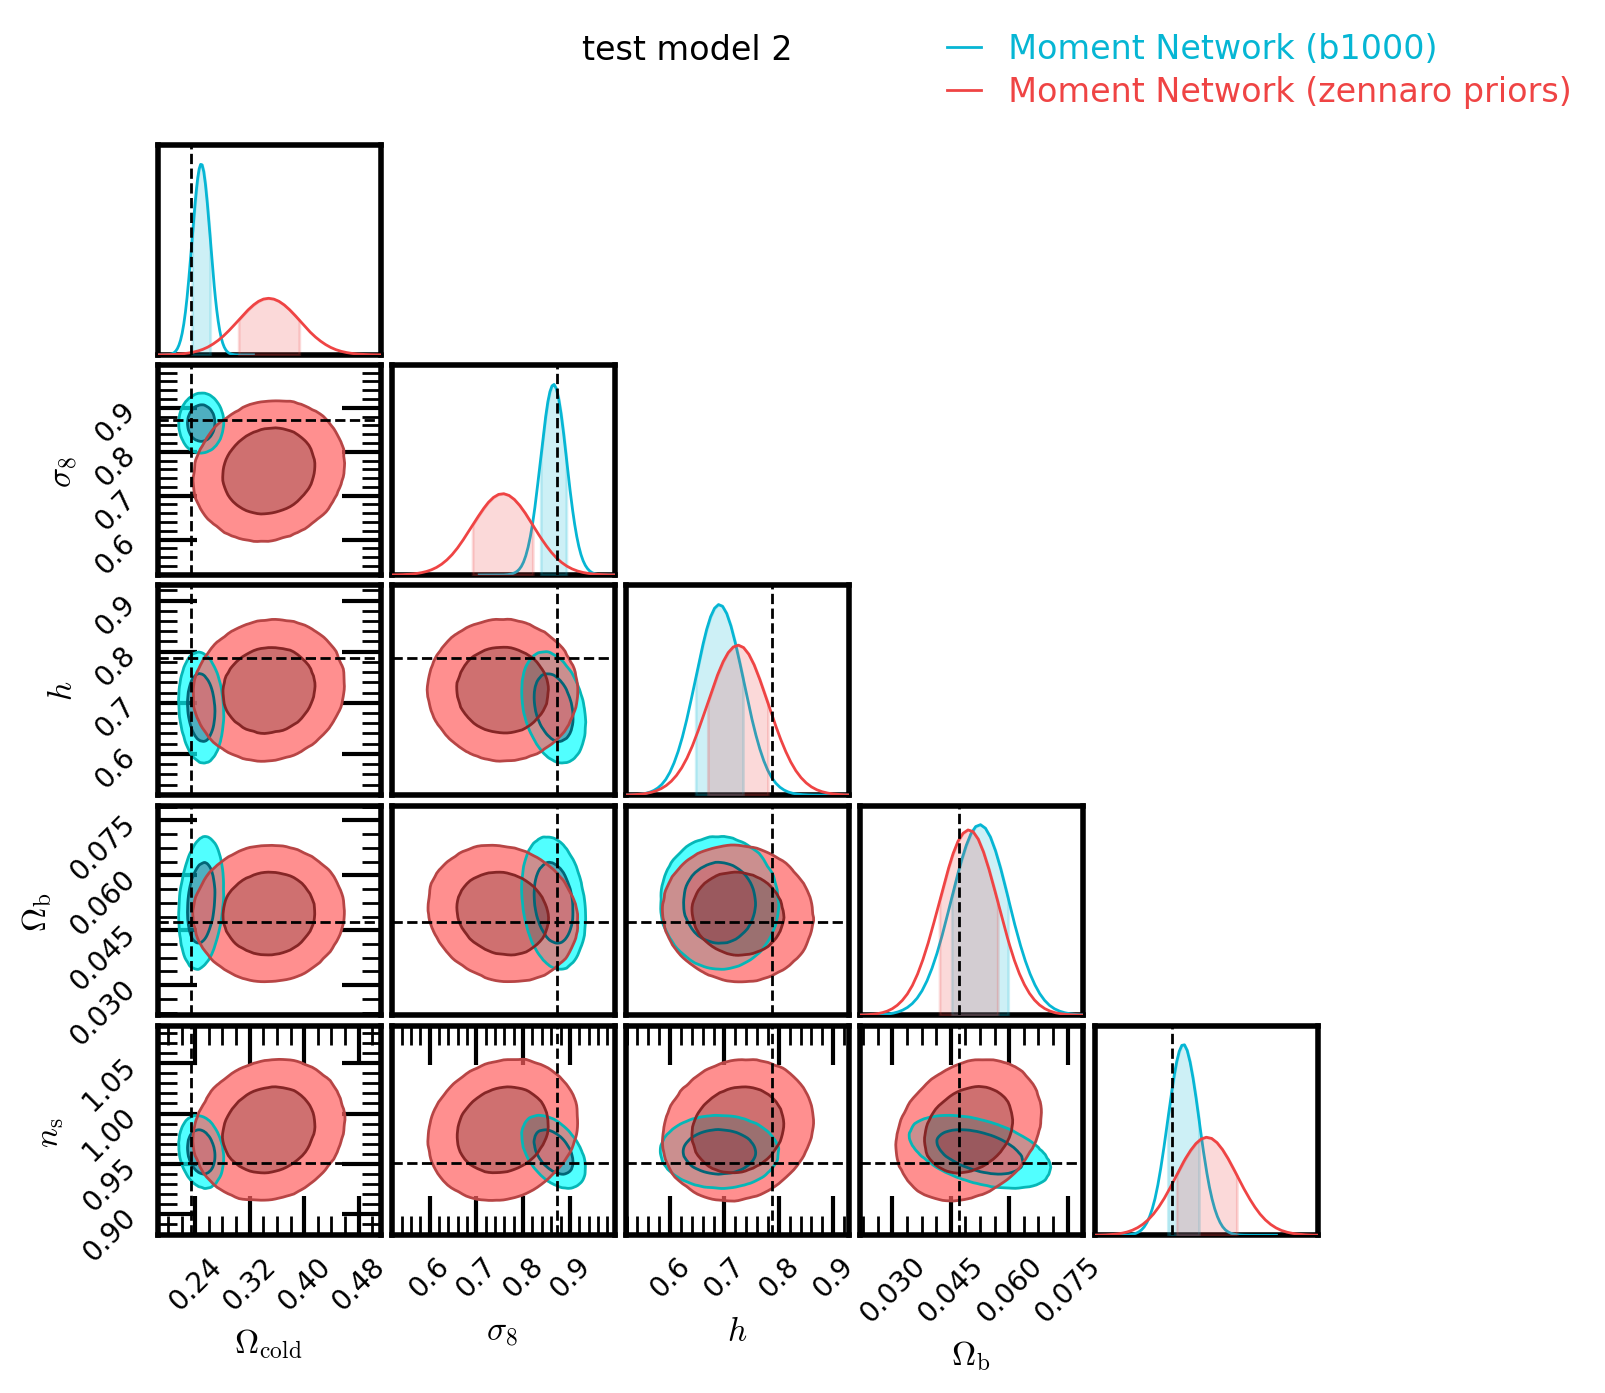

In [26]:
inf_methods = ['mn', 
               'mn']

tags_inf = [
    '_muchisimocksPk_p5_n10000_b1000_ntrain3500_direct_best-rand10',
    '_muchisimocksPk_p5_n10000_biaszen_p4_n10000_ntrain3500_direct_best-rand10',
            ]

labels_extra = ['(b1000)', 
                '(zennaro priors)', 
                ]
#colors = [utils.color_dict_methods[meth] for meth in methods]
#colors = ['#63E0CF', 'cyan', 'blue', '#2E3CA2']
colors = ['cyan', 
          'red']

for idx_obs in range(3):
    theta_obs_true = theta_test[idx_obs]
    plotter.plot_contours_inf(param_names, idx_obs, theta_obs_true, 
                            inf_methods, tags_inf, 
                            colors=colors, labels_extra=labels_extra)



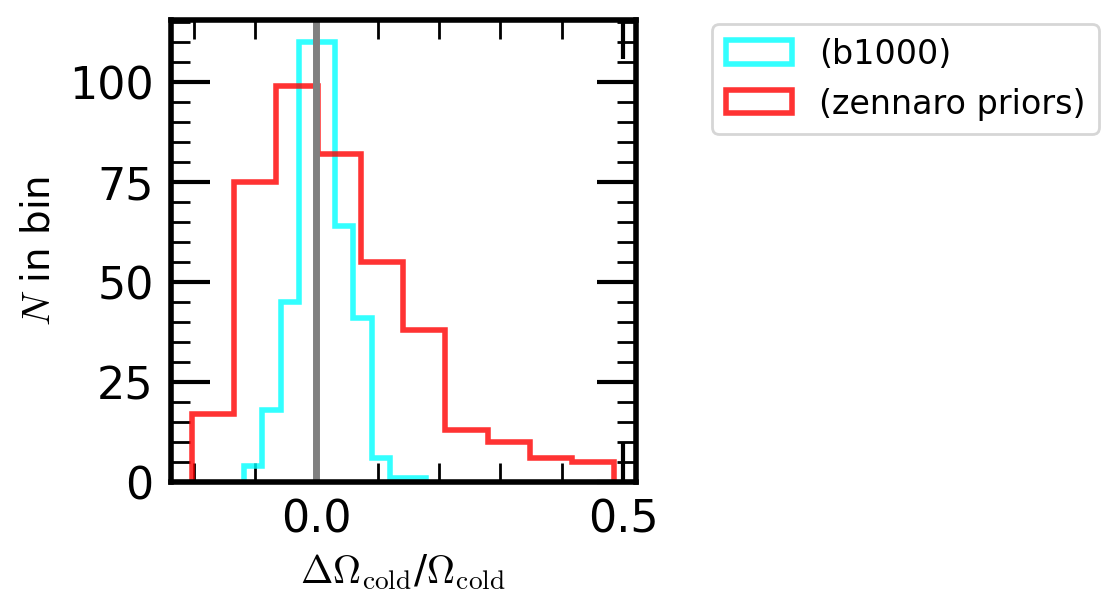

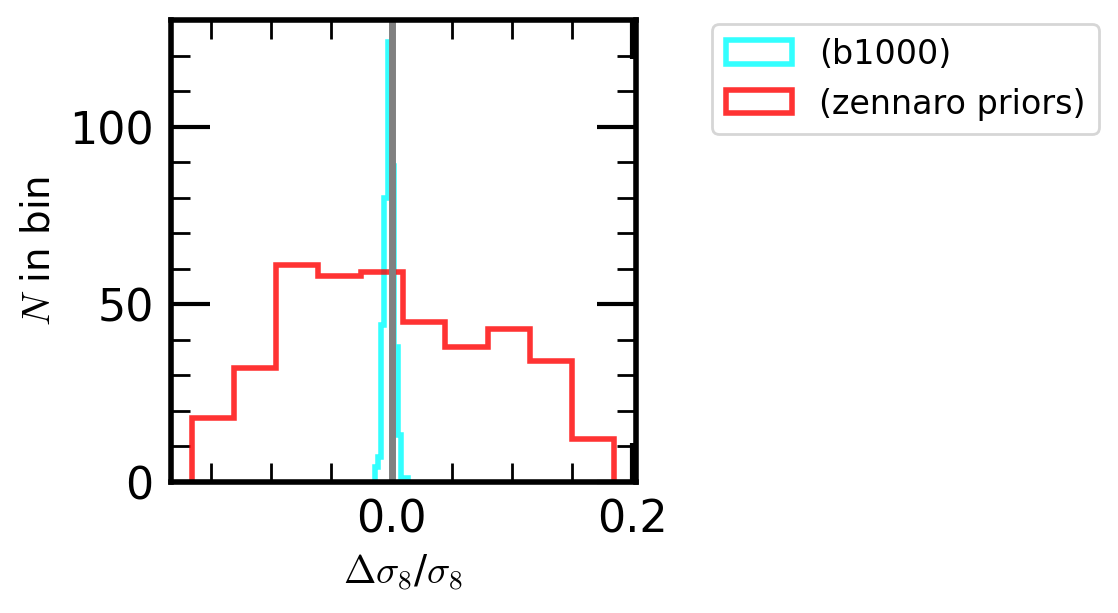

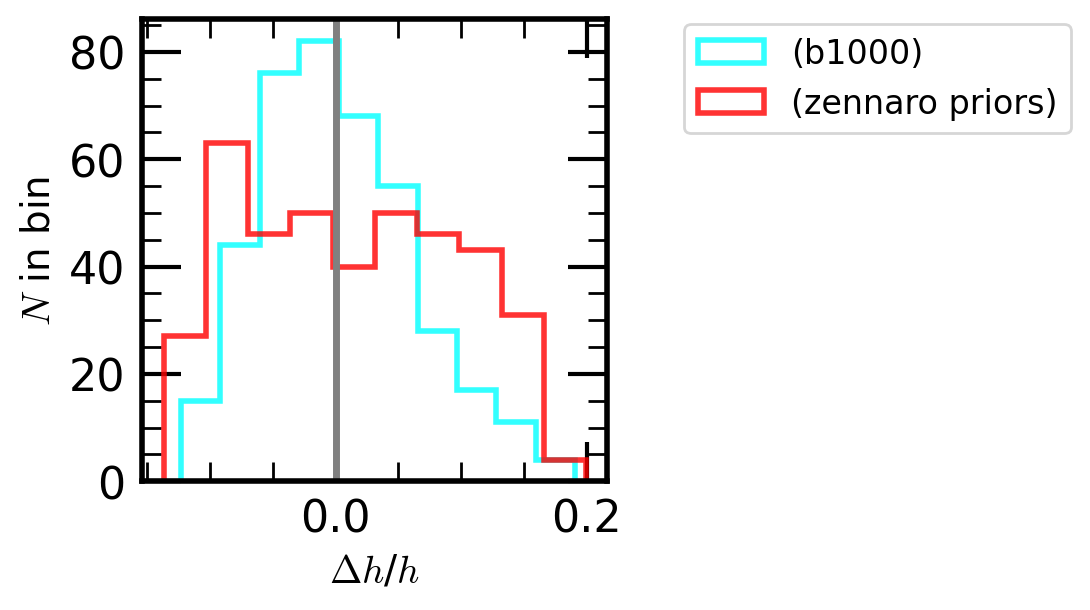

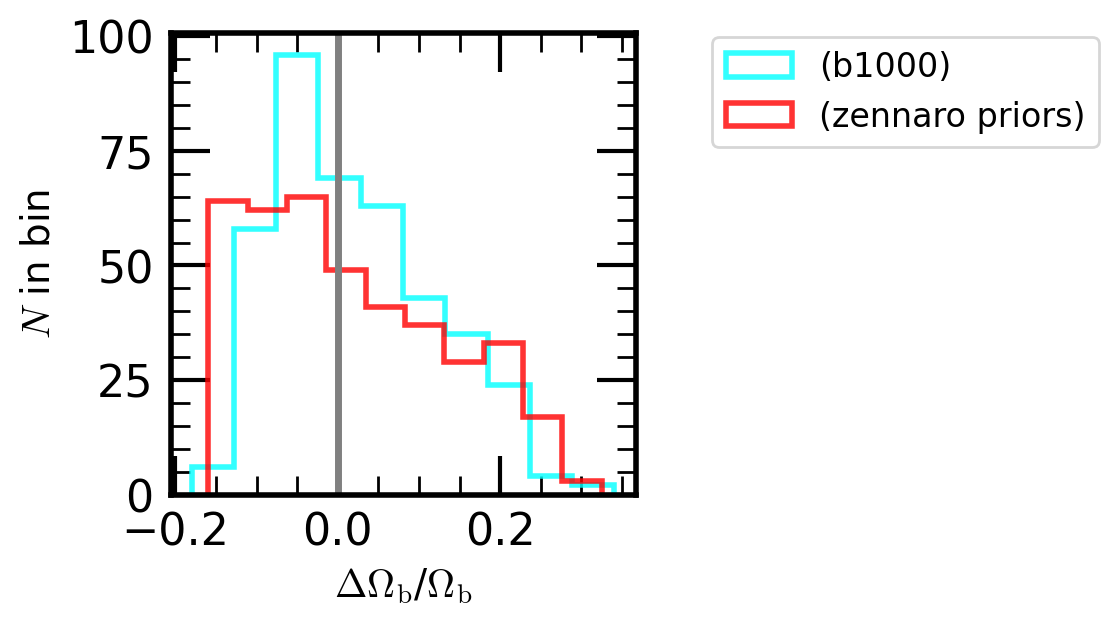

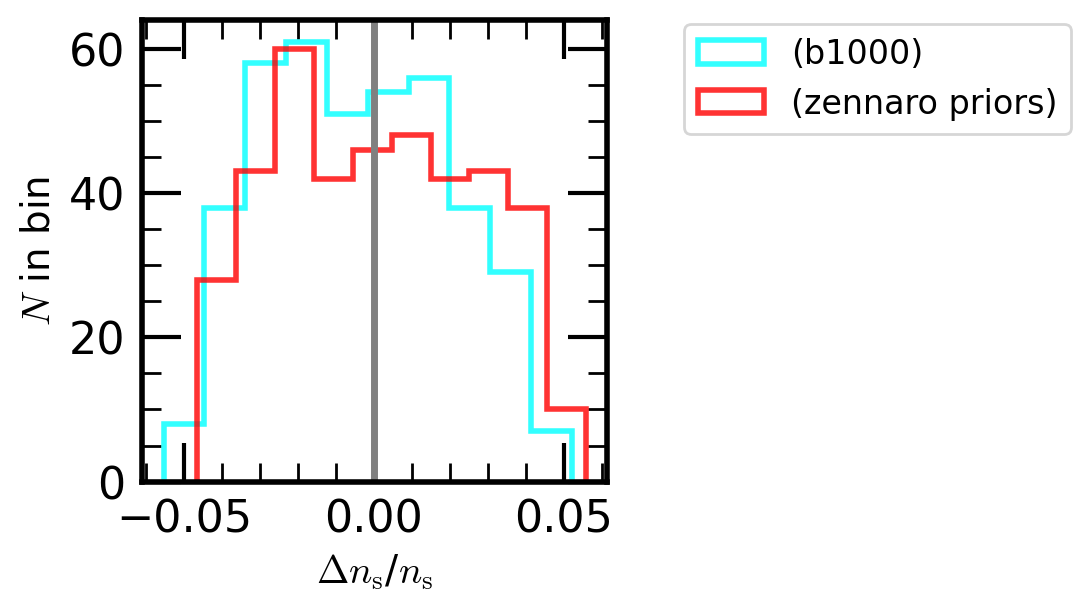

In [27]:
inf_methods = ['mn', 
               'mn'
               ]

tags_inf = [
    
    '_muchisimocksPk_p5_n10000_b1000_ntrain3500_direct_best-rand10',
    #'_muchisimocksPk_p5_n10000_b1000_ntrain3000_direct',
    '_muchisimocksPk_p5_n10000_biaszen_p4_n10000_ntrain3500_direct_best-rand10',
            ]

labels_extra = ['(b1000)', 
                '(zennaro priors)', 
                ]
#colors = [utils.color_dict_methods[meth] for meth in methods]
#colors = ['#63E0CF', 'cyan', 'blue', '#2E3CA2']
colors = ['cyan', 
          'red']

fracdiffs_arr = []
for tag_inf in tags_inf:
    _theta_test_pred, _  = utils.get_moments_test_mn(tag_inf)
    fracdiffs_mn = (_theta_test_pred - theta_test)/theta_test
    fracdiffs_arr.append(fracdiffs_mn)
fracdiffs_arr = np.array(fracdiffs_arr)

plotter.plot_hists_mean(fracdiffs_arr, param_labels, 
                        color_arr=colors, label_arr=labels_extra,
                        bins=10, alpha=0.8, histtype='step')


/dipc/kstoreyf/muchisimocks/scripts/plotter.py:94: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(np.diag(cov_pred))


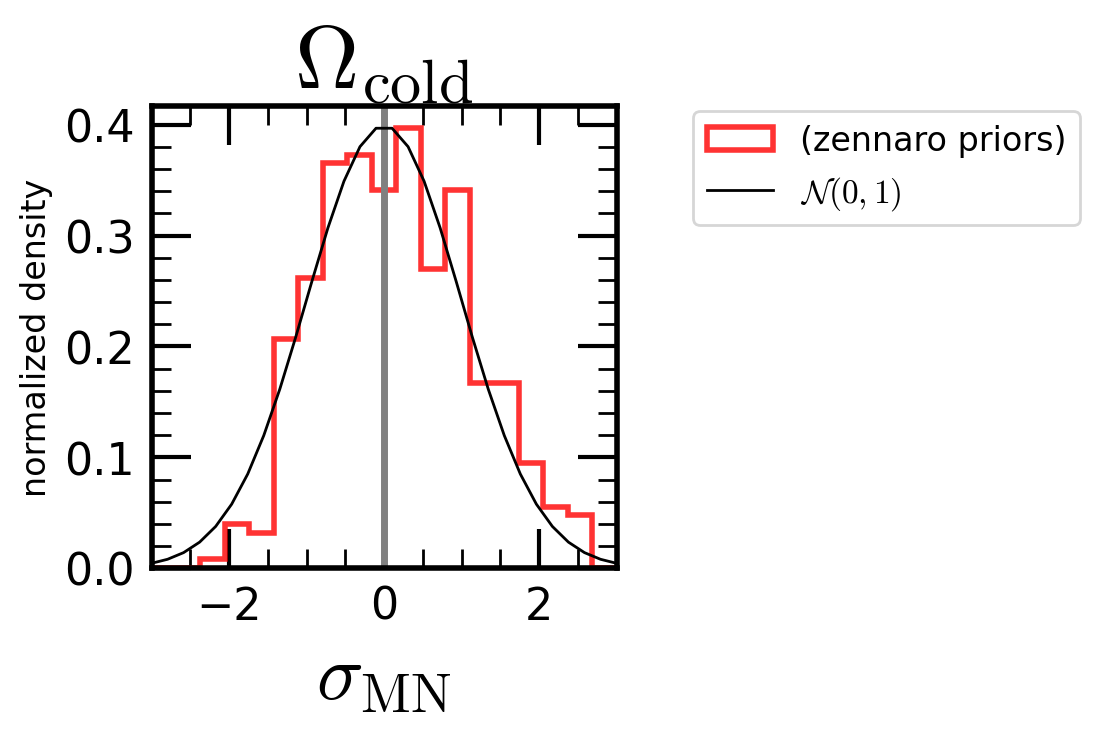

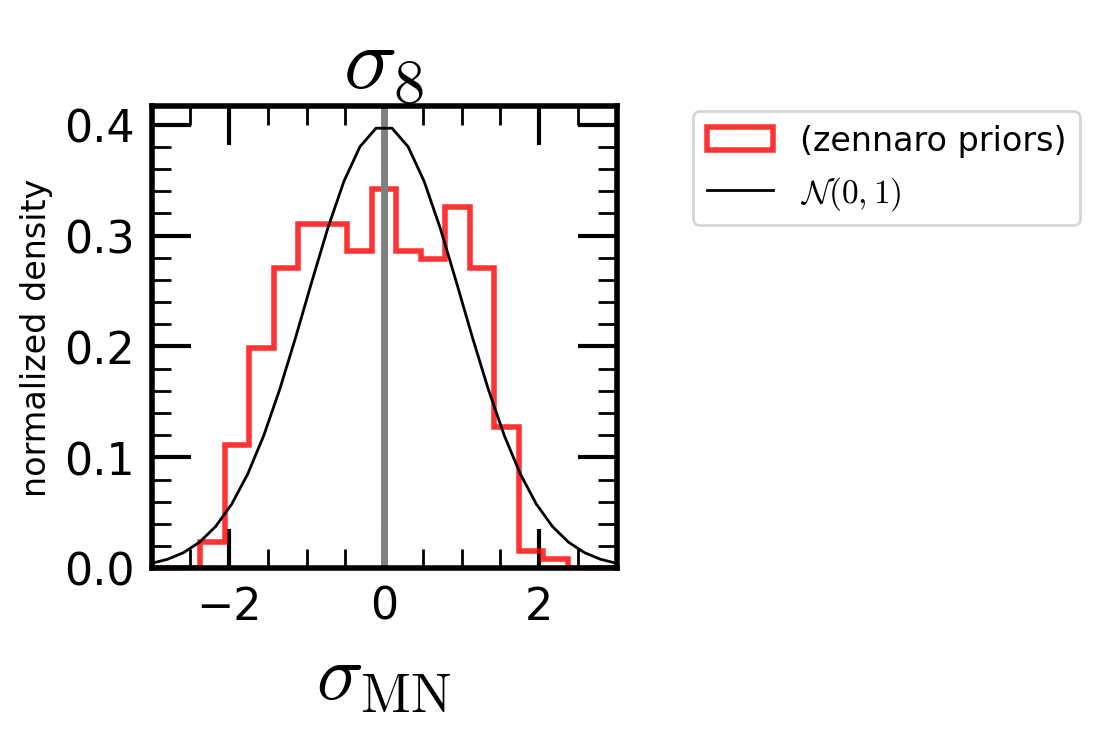

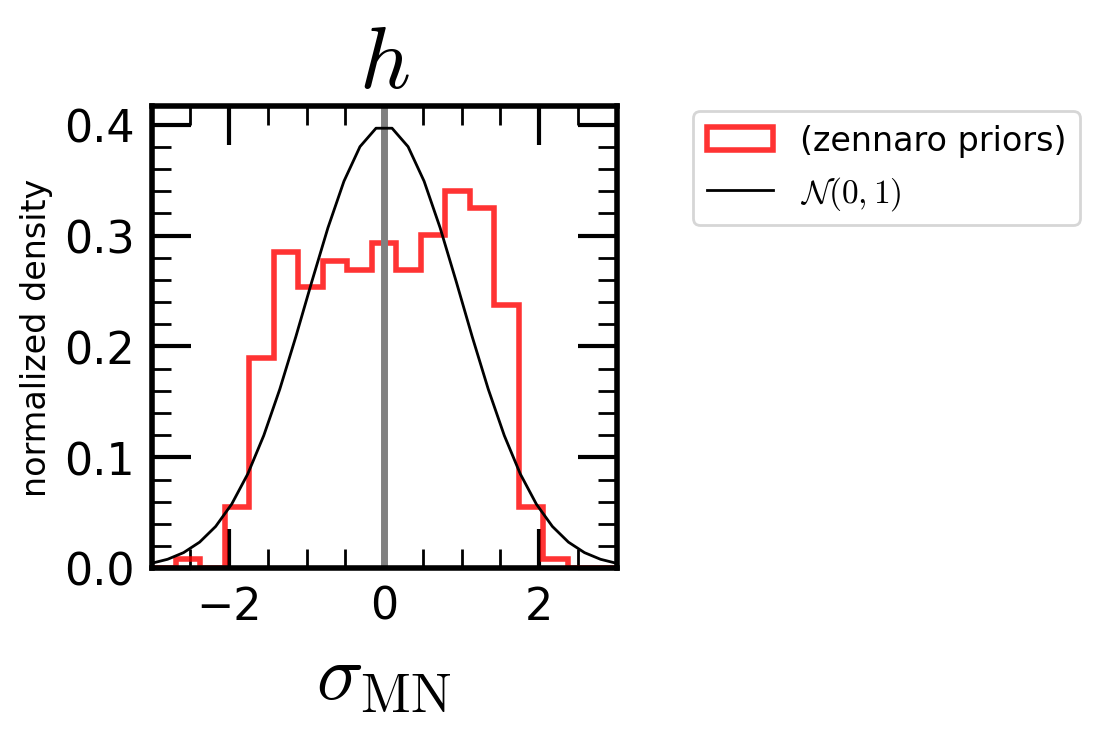

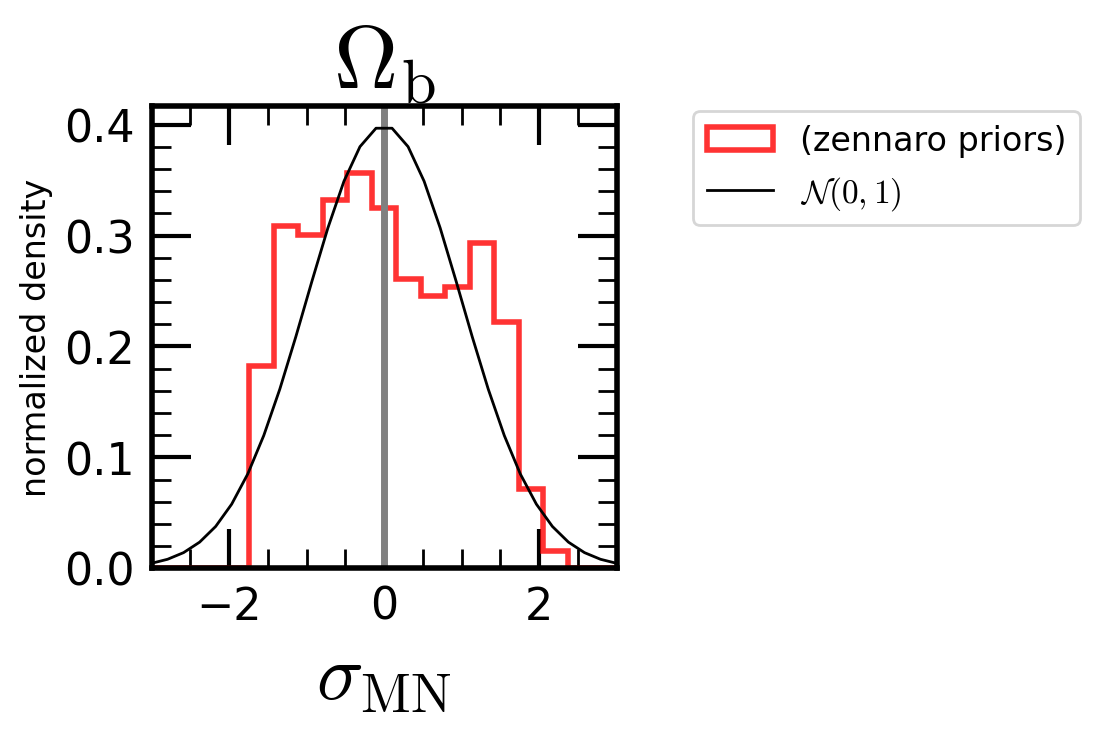

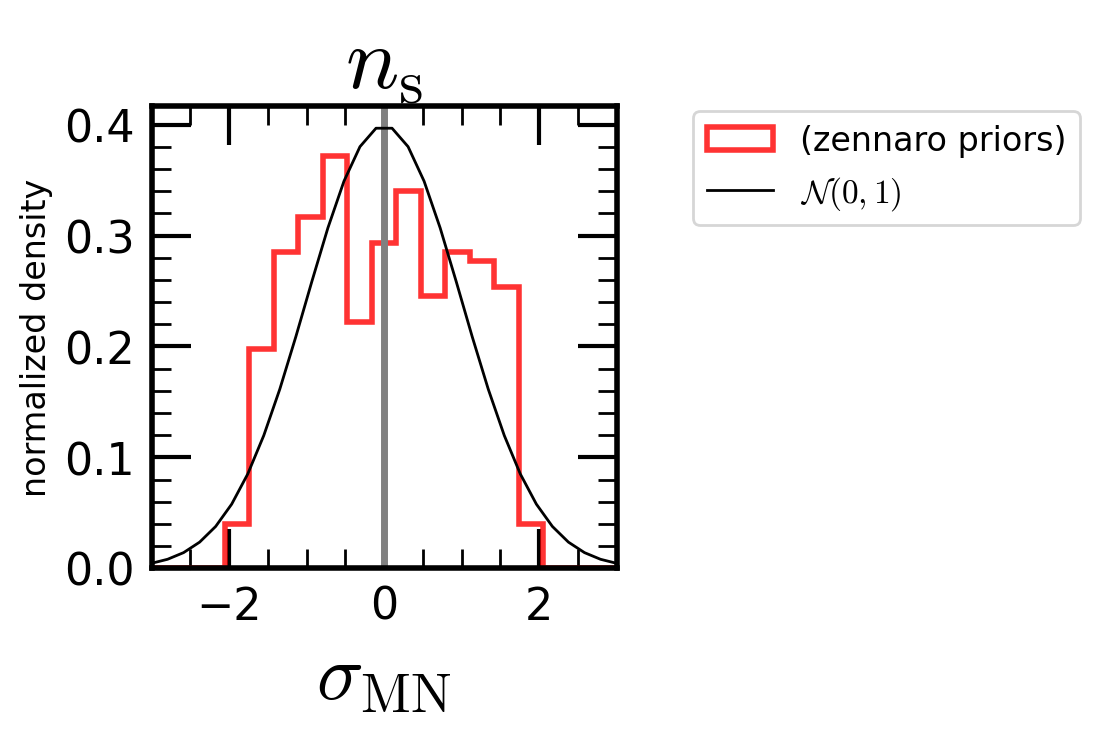

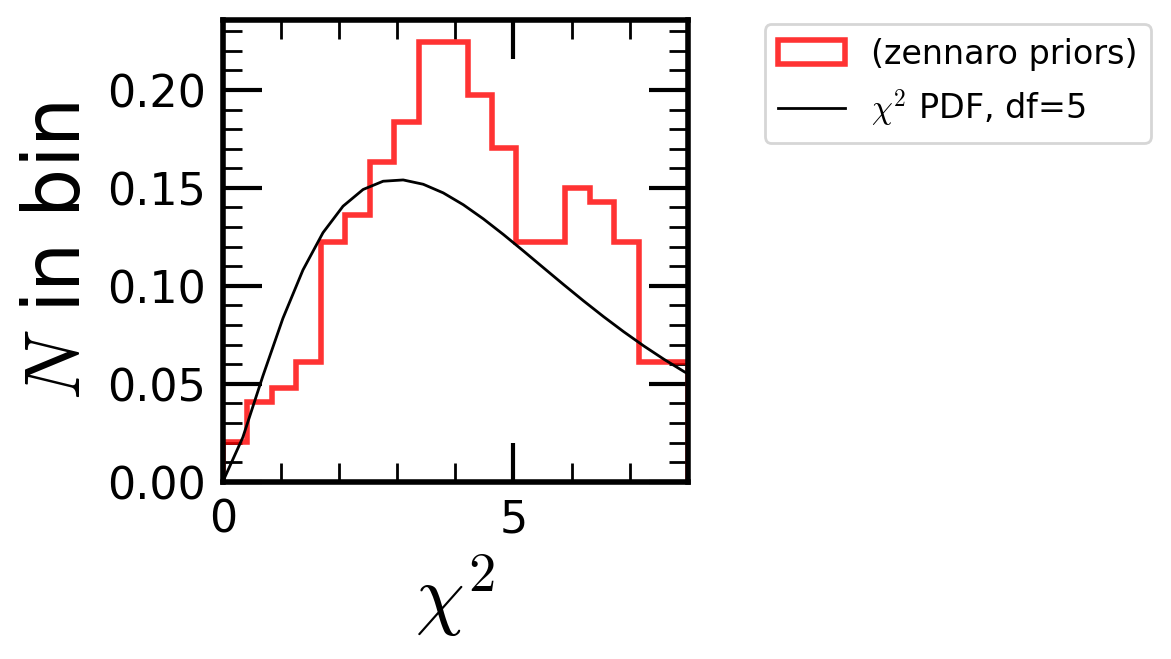

In [25]:
inf_methods = [#'mn', 
               'mn']

tags_inf = [
    
    #'_muchisimocksPk_p5_n10000_b1000_ntrain3500_direct_best-rand10',
    #'_muchisimocksPk_p5_n10000_b1000_ntrain3000_direct',
    '_muchisimocksPk_p5_n10000_biaszen_p4_n10000_ntrain3500_direct_best-rand10',
            ]

labels_extra = [#'(b1000)', 
                '(zennaro priors)', 
                ]
#colors = [utils.color_dict_methods[meth] for meth in methods]
#colors = ['#63E0CF', 'cyan', 'blue', '#2E3CA2']
colors = [#'cyan', 
          'red']

theta_true_arr, theta_pred_arr, covs_pred_arr = [], [], []
for tag_inf in tags_inf:
    _theta_test_pred, _covs_test_pred  = utils.get_moments_test_mn(tag_inf)
    theta_true_arr.append(theta_test)
    theta_pred_arr.append(_theta_test_pred)
    covs_pred_arr.append(_covs_test_pred)
theta_true_arr = np.array(theta_true_arr)
theta_pred_arr = np.array(theta_pred_arr)
covs_pred_arr = np.array(covs_pred_arr)

plotter.plot_hists_cov(theta_true_arr, theta_pred_arr, covs_pred_arr, param_labels,
                        color_arr=colors, label_arr=labels_extra,
                        #bins=10, 
                        alpha=0.8, histtype='step')
